In [2]:
pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 1.0/124.9 MB 5.6 MB/s eta 0:00:23
    --------------------------------------- 2.1/124.9 MB 5.9 MB/s eta 0:00:21
   - -------------------------------------- 3.4/124.9 MB 5.6 MB/s eta 0:00:22
   - -------------------------------------- 4.7/124.9 MB 5.8 MB/s eta 0:00:21
   - -------------------------------------- 6.0/124.9 MB 6.0 MB/s eta 0:00:20
   -- ------------------------------------- 7.1/124.9 MB 5.5 MB/s eta 0:00:22
   -- ------------------------------------- 8.4/124.9 MB 5.7 MB/s eta 0:00:21
   --- ------------------------------------ 9.4/124.9 MB 5.7 MB/s eta 0:00:21
   --- ------------------------------------ 9.4/124.9 MB 5.7 MB/s eta 0:00:21
   --- ------------------------------------ 10.2/124.9 MB 4.8 MB/s eta 0:00:24
   --- ------------------------------------ 11.3/124.9 MB 4.9 MB/s eta 0:00:24
   ---- ----------------------------------- 12.8/124.9 MB 5.0 MB/s e

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report
from xgboost import XGBClassifier
import pickle

In [39]:
delivery = pd.read_csv('deliveries.csv')
match = pd.read_csv('matches.csv')

In [40]:
match.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [41]:
match.shape

(756, 18)

In [42]:
delivery.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [43]:
delivery.shape

(179078, 21)

In [44]:
print("\nTop Cities:\n", match['city'].value_counts().head())
print("\nTop Teams:\n", pd.concat([match['team1'], match['team2']]).value_counts().head())


Top Cities:
 city
Mumbai       101
Kolkata       77
Delhi         74
Bangalore     66
Hyderabad     64
Name: count, dtype: int64

Top Teams:
 Mumbai Indians                 187
Royal Challengers Bangalore    180
Kolkata Knight Riders          178
Kings XI Punjab                176
Chennai Super Kings            164
Name: count, dtype: int64


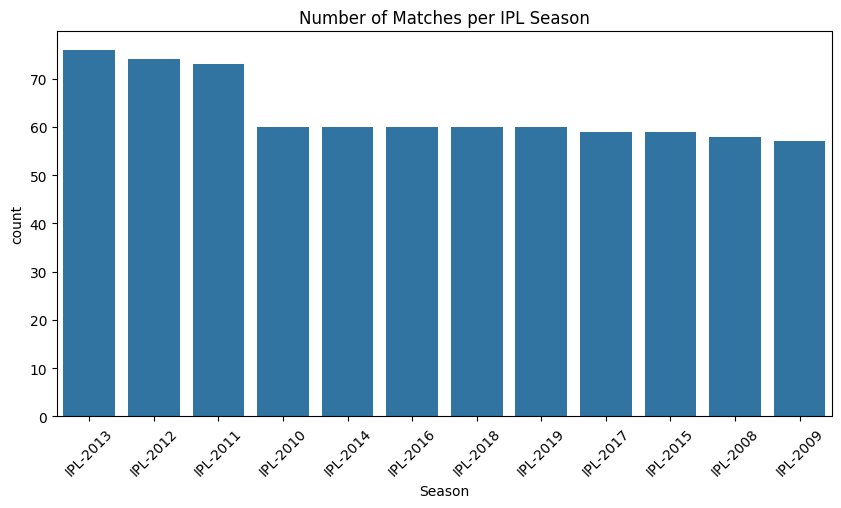

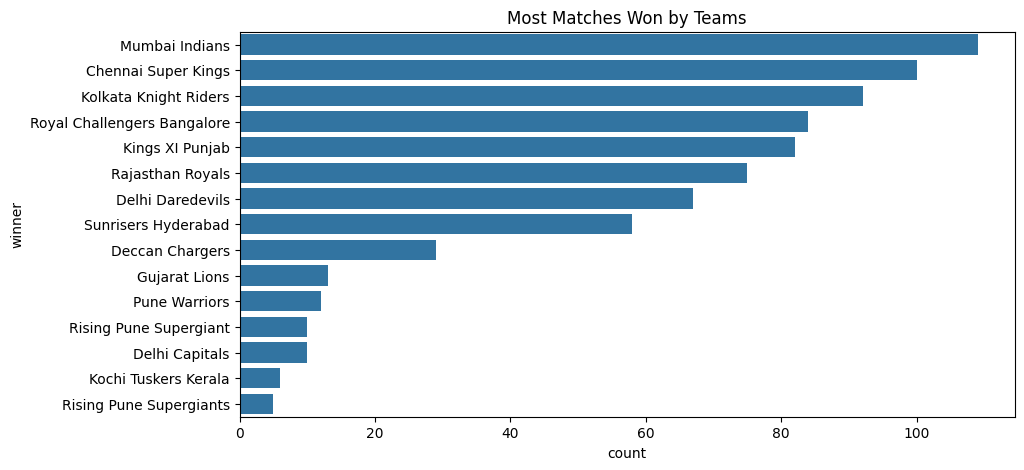

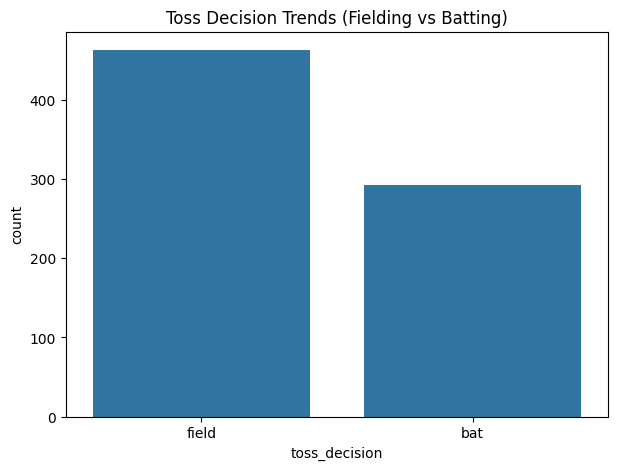

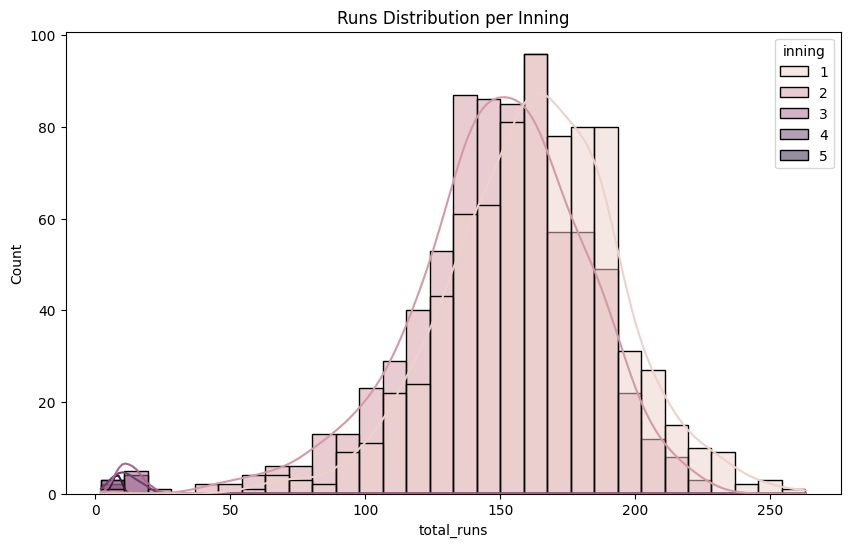

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(data=match, x='Season', order=match['Season'].value_counts().index)
plt.title("Number of Matches per IPL Season")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(data=match, y='winner', order=match['winner'].value_counts().index)
plt.title("Most Matches Won by Teams")
plt.show()

plt.figure(figsize=(7,5))
sns.countplot(data=match, x='toss_decision')
plt.title("Toss Decision Trends (Fielding vs Batting)")
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(data=delivery.groupby(['match_id','inning'])['total_runs'].sum().reset_index(),
             x='total_runs', hue='inning', bins=30, kde=True)
plt.title("Runs Distribution per Inning")
plt.show()


In [47]:
df = delivery.merge(match, left_on="match_id", right_on="id")

In [48]:
df = df[df['result'] != 'no result']

In [49]:

target_runs = df.groupby('match_id')['total_runs'].transform('max')

df['cum_runs'] = df.groupby('match_id')['total_runs'].cumsum()

df['runs_left'] = target_runs - df['cum_runs']

df['balls_bowled'] = (df['over'] - 1) * 6 + df['ball']
df['balls_left'] = 120 - df['balls_bowled']

In [50]:
df['wickets_left'] = 10 - df.groupby('match_id')['player_dismissed'].transform(lambda x: x.notnull().cumsum())

In [51]:


df['cum_runs'] = df.groupby('match_id')['total_runs'].cumsum()
df['crr'] = df['cum_runs'] * 6 / df['balls_bowled'].replace(0, 1)


In [52]:
df['rrr'] = df['runs_left'] * 6 / df['balls_left'].replace(0,1)

In [53]:
df['target'] = np.where(df['winner'] == df['batting_team'], 1, 0)

In [54]:
features = df[['batting_team','bowling_team','city','runs_left','balls_left','wickets_left','total_runs','crr','rrr']]
labels = df['target']

In [55]:
features = features.dropna()
labels = labels.loc[features.index]

In [56]:
categorical_cols = ["batting_team", "bowling_team", "city"]

trf = ColumnTransformer([
    ("encoder", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
], remainder="passthrough")


In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)


In [58]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)


In [59]:
param_grid = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [5, 8, 10],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "reg_lambda": [1, 2, 5],
    "reg_alpha": [0, 0.5, 1]
}

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring="roc_auc",
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

pipe = Pipeline([
    ("transformer", trf),
    ("xgb", search)
])

In [64]:
pipe.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\users\balaji\appdata\local\programs\python\python38\lib\site-packages\xgboost\core.py:158: UserWarning: [20:41:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('xgb',
                 RandomizedSearchCV(cv=3,
                                    estimator=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            devi...
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...),
                                    n_iter=20, n_jobs=-1,
                                    param_distributions={'colsample_bytree': [0.7,
                                                                              0.8,
                                                                              1.0],
                                                         'learning_rate': [0.01,
                                                                           0.05,
                                                                           0.1],
                                                         'max_depth': [5, 8,
                                                                       10],
                                                         'n_estimators': [300,
                                                                          500,
                                                                          800],
                                                         'reg_alpha': [0, 0.5,
                                                                       1],
                                                         'reg_lambda': [1, 2,
                                                                        5],
                                                         'subsample': [0.7, 0.8,
                                                                       1.0]},
                                    random_state=42, scoring='roc_auc',
                                    verbose=2))])

In [65]:
y_pred = pipe.predict(X_test)
y_pred_probs = pipe.predict_proba(X_test)[:, 1]

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ ROC AUC:", roc_auc_score(y_test, y_pred_probs))
print("✅ Log Loss:", log_loss(y_test, y_pred_probs))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.9748319303994125
✅ ROC AUC: 0.9974537635491356
✅ Log Loss: 0.07795929770772611

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     18083
           1       0.97      0.97      0.97     17319

    accuracy                           0.97     35402
   macro avg       0.97      0.97      0.97     35402
weighted avg       0.97      0.97      0.97     35402



In [66]:
with open("pipe.pkl", "wb") as f:
    pickle.dump(pipe, f)

print("🎉 Optimized XGBoost model saved as pipe.pkl")

🎉 Optimized XGBoost model saved as pipe.pkl
